# Build Notes

In [2]:
using Revise
using FUSE
using IMAS
using Printf
using Plots;
FUSE.logging(Logging.Info);

[ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]


## Initialize FPP v1_demount

In [3]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars);

ini.build.plasma_gap = 0.125
ini.equilibrium.R0 = 4.5
ini.equilibrium.B0 = 5.5
ini.requirements.flattop_duration = 100.0 * 3600.0


R0 = ini.equilibrium.R0
ϵ = ini.equilibrium.ϵ
a = R0 * ϵ

RiPlasma = R0 - a

delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

# HFS layers

ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
ini.build.layers[:hfs_first_wall] = 0.02
ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
    - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
ini.build.layers[:OH] = rbCenterPost * 0.25
ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

# LFS layers

ini.build.layers[:lfs_first_wall] = 0.02
ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.2
ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]


display(R0)
display(a)
display(rbCenterPost)
display(RiPlasma - a*ini.build.plasma_gap)
display(RiPlasma)
ini.build.layers

# do scale_build_layers 

gap = a * ini.build.plasma_gap
plasma_start = R0 - a - gap
layer_plasma_start = 0.0
for (layer, thickness) in ini.build.layers
    if layer == :plasma
        break
    end
    if thickness > 0.0
        layer_plasma_start += thickness
    end
end
    
display(plasma_start)
display(layer_plasma_start)

ini.build.layers

4.5

1.2857142857142856

1.7176660850891012

3.053571428571429

3.2142857142857144

3.053571428571429

3.053571428571429

OrderedCollections.OrderedDict{Symbol, Float64} with 24 entries:
  :gap_OH                                 => 0.794547
  :OH                                     => 0.429417
  :gap_TF_OH                              => 0.0642857
  :hfs_TF                                 => 0.429417
  :hfs_gap_low_temp_shield_TF             => 0.0642857
  :hfs_low_temp_shield                    => 0.318143
  :hfs_gap_vacuum_vessel_low_temp_shield  => 0.0642857
  :hfs_vacuum_vessel                      => 0.160714
  :hfs_gap_high_temp_shield_vacuum_vessel => 0.0642857
  :hfs_high_temp_shield                   => 0.160714
  :hfs_blanket                            => 0.483477
  :hfs_first_wall                         => 0.02
  :plasma                                 => 2.89286
  :lfs_first_wall                         => 0.02
  :lfs_blanket                            => 0.785401
  :lfs_high_temp_shield                   => 0.160714
  :lfs_gap_high_temp_shield_vacuum_vessel => 0.642857
  :lfs_vacuum_vessel  

In [4]:
dd = IMAS.dd()
FUSE.init(dd, ini, act; do_plot=false);

In [5]:
display(dd.build.layer)
plot(dd.build)
dd.build.layer[11].identifier

24×9 DataFrame
 Row │ group   details     type      ΔR         R_start    R_end      material      area       volume     
     │ String  String      String    Float64    Float64    Float64    String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            0.794598    0.0        0.794598                 9.97408     24.8983
   2 │ in                  oh        0.429444    0.794598   1.22404   ReBCO          5.39053     34.1854
   3 │ in                            0.0642898   1.22404    1.28833                  0.806989     6.36944
   4 │ hfs                 tf        0.429444    1.28833    1.71778   ReBCO         13.4926     145.626
   5 │ hfs                           0.0642898   1.71778    1.78206                  2.13415     62.2251
   6 │ hfs     low temp    shield    0.318163    1.78206    2.10023   Steel          9.09611    264.789
   7 │ hfs                         

2

## Experiment with HFS build settings

In [6]:
act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.aspect_ratio_tolerance = 0.0
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing

ActorHFSsizing{Float64}
├─ j_tolerance ➡ 0.5 Tolerance on the OH and TF current limits (overrides ActorFluxSwing.j_tolerance)
├─ stress_tolerance ➡ 0.01 Tolerance on the OH and TF structural stresses limits
├─ aspect_ratio_tolerance ➡ 0.0 Tolerance on the aspect_ratio change
├─ do_plot ➡ true Plot
└─ verbose ➡ true Verbose


 * Status: success

 * Candidate solution
    Final objective value:     2.824346e-04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    214
    f(x) calls:    415


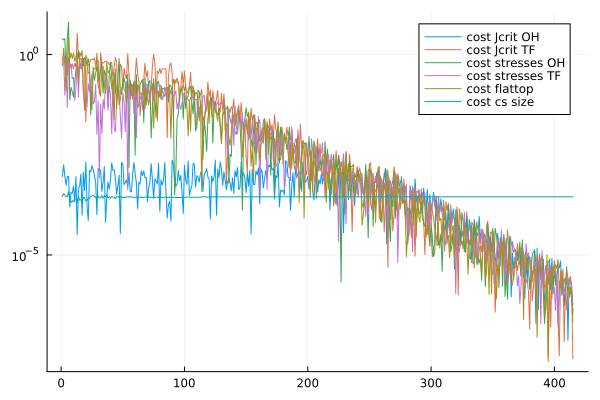

[OH.thickness, dd.build.oh.technology.fraction_stainless] = [0.38813137359818484, 0.7142656749173418]
[TFhfs.thickness, dd.build.tf.technology.fraction_stainless] = [0.43739316811195295, 0.8124394326724176]

target_B0 = 5.5
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 5.5

dd.build.oh.flattop_duration = 359999.9212910112
dd.requirements.flattop_duration = 360000.0

dd.build.oh.max_j = 3.99608126920678e7
dd.build.oh.critical_j = 5.994123960219315e7

dd.build.tf.max_j = 3.050128878037391e7
dd.build.tf.critical_j = 4.575193433791801e7

maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh) = 7.920795291390578e8
stainless_steel.yield_strength = 8.0e8

maximum(dd.solid_mechanics.center_stack.stress.vonmises.tf) = 7.920796543808209e8
stainless_steel.yield_strength = 8.0e8

old_R0 / a = 3.1115208607978713
R0 / a = 3.1115208607978713


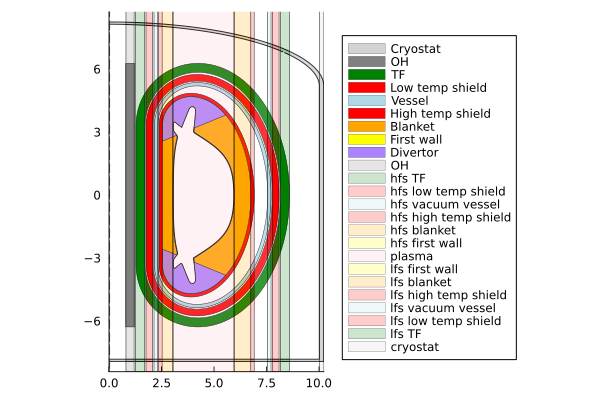

In [7]:
FUSE.ActorHFSsizing(dd, act);

In [8]:
using Printf

@printf("OH R_start = %.2f m\n", dd.build.layer[2].start_radius)
@printf("OH R_end   = %.2f m\n",dd.build.layer[2].end_radius)

@printf("TF R_start = %.2f m\n", dd.build.layer[4].start_radius)
@printf("TF R_end   = %.2f m\n",dd.build.layer[4].end_radius)

#display(dd.build.tf)
#display(dd.build.oh)

tf_j_max = dd.build.tf.max_j
oh_j_max = dd.build.oh.max_j

tf_j_crit = dd.build.tf.critical_j
oh_j_crit = dd.build.oh.critical_j

tf_vms_max = (maximum(abs.(dd.solid_mechanics.center_stack.stress.vonmises.tf)))
oh_vms_max = (maximum(abs.(dd.solid_mechanics.center_stack.stress.vonmises.oh)))


@printf("\n")
@printf("TF stainless_fraction = %.3f\n", dd.build.tf.technology.fraction_stainless)
@printf("OH stainless_fraction = %.3f\n", dd.build.oh.technology.fraction_stainless)

@printf("\n")
@printf("TF J_op = %.1f MA\n", tf_j_max/1e6)
#@printf("TF J_max = %.1f MA\n", tf_j_crit*(1-act.ActorHFSsizing.j_tolerance)/1e6)
@printf("TF J_crit = %.1f MA\n", tf_j_crit/1e6)

@printf("\n")
@printf("OH J_op = %.1f MA\n", oh_j_max/1e6)
#@printf("OH J_max = %.1f MA\n", oh_j_crit*(1-act.ActorHFSsizing.j_tolerance)/1e6)
@printf("OH J_crit = %.1f MA\n", oh_j_crit/1e6)

@printf("\n")
@printf("TF stress_op = %.1f MPa\n", tf_vms_max/1e6)
#@printf("TF stress_max = %.1f MPa\n", 800*(1-act.ActorHFSsizing.stress_tolerance))
@printf("TF stress_crit = %.1f MPa\n", 800)

@printf("\n")
@printf("OH stress_op = %.1f MPa\n", oh_vms_max/1e6)
#@printf("OH stress_max = %.1f MPa\n", 800*(1-act.ActorHFSsizing.stress_tolerance))
@printf("OH stress_crit = %.1f MPa\n", 800)




OH R_start = 0.81 m
OH R_end   = 1.19 m
TF R_start = 1.26 m
TF R_end   = 1.69 m

TF stainless_fraction = 0.812
OH stainless_fraction = 0.714

TF J_op = 30.5 MA
TF J_crit = 45.8 MA

OH J_op = 40.0 MA
OH J_crit = 59.9 MA

TF stress_op = 792.1 MPa
TF stress_crit = 800.0 MPa

OH stress_op = 792.1 MPa
OH stress_crit = 800.0 MPa


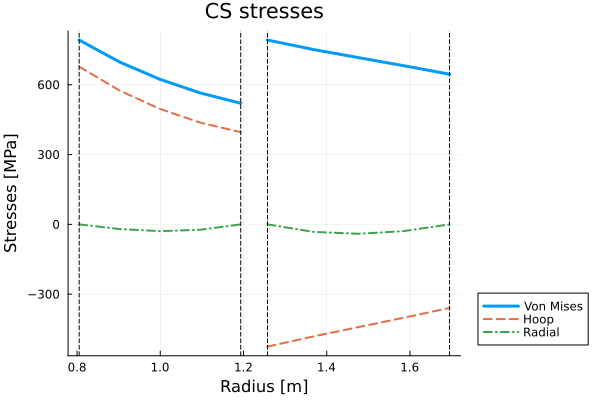

In [9]:
plot(dd.solid_mechanics.center_stack.stress)

## Change CX build settings

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 4.5 [m]                   B0 → 5.5 [T]                   Te0 → 19.5 [keV]               ne0 → 2.63e+20 [m⁻³]           
a → 1.29 [m]                   ip → 8 [MA]                    Ti0 → 19.5 [keV]               ne_ped → 1.16e+20 [m⁻³]        
1/ϵ → 3.5 [m]                  q95 → 5.53                     <Te> → 8.39 [keV]              <ne> → 1.69e+20 [m⁻³]          
κ → 2.32                       <Bpol> → 0.697 [T]             <Ti> → 8.39 [keV]              ne0/<ne> → 1.56                
δ → 0.75                       βpol_MHD → 3.49                Te0/<Te> → 2.32                fGW → 1.26                     
ζ → -0.0578                    βtor_MHD → 0.0591              Ti0/<Ti> → 2.32                zeff_ped → 2                   


​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start    R_end      material      area       volume     
     │ String  String      String    Float64    Float64    Float64    String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            0.805186    0.0        0.805186                 9.97408     24.8983
   2 │ in                  oh        0.388131    0.805186   1.19332   ReBCO          5.39053     34.1854
   3 │ in                            0.0642898   1.19332    1.25761                  0.806989     6.36944
   4 │ hfs                 tf        0.437393    1.25761    1.695     ReBCO         13.4926     143.696
   5 │ hfs                           0.0642898   1.695      1.75929                  2.13415     62.2251
   6 │ hfs     low temp    shield    0.318163    1.75929    2.07745   Steel          9.09611    264.789
   7 │ hfs                         

​


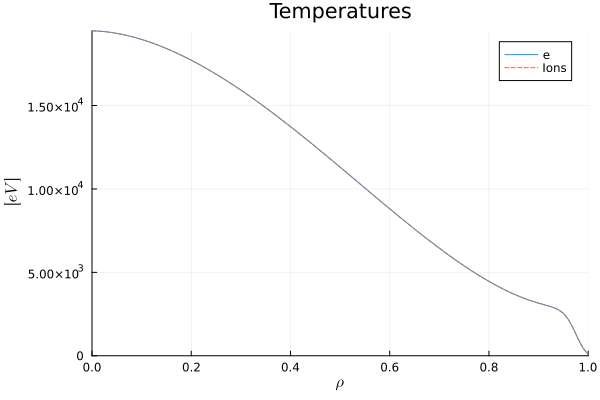

​


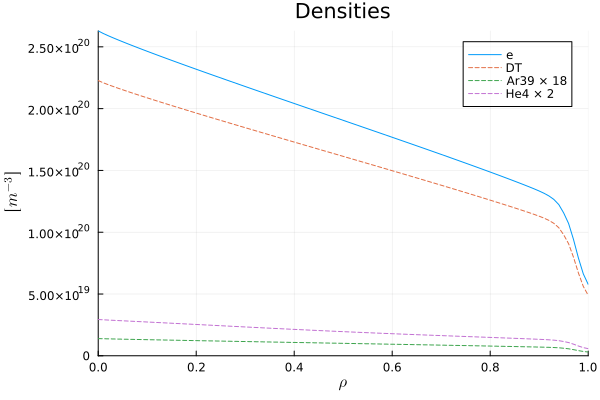

​


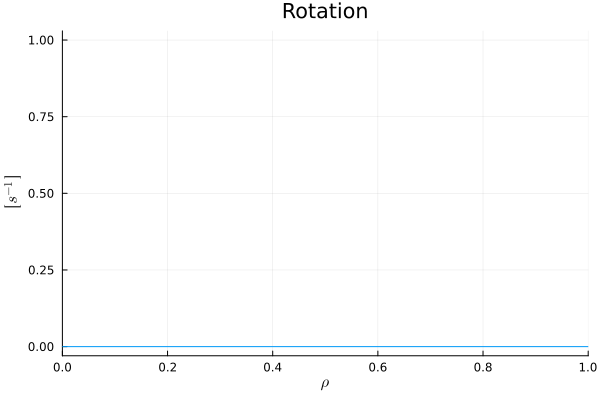

​


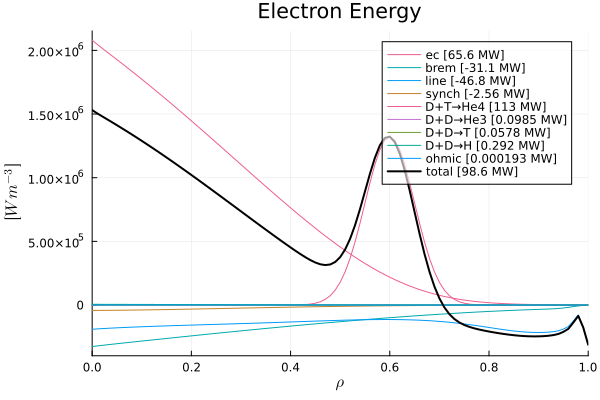

​


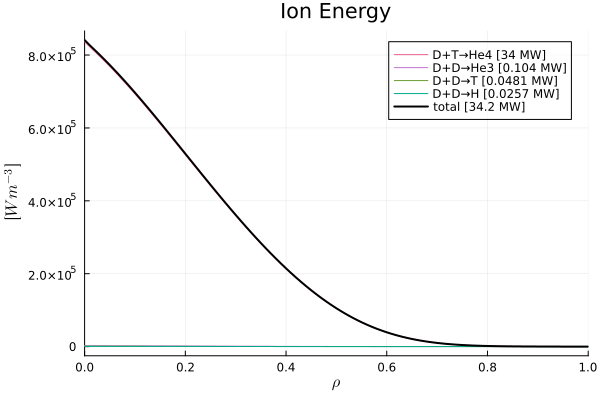

​


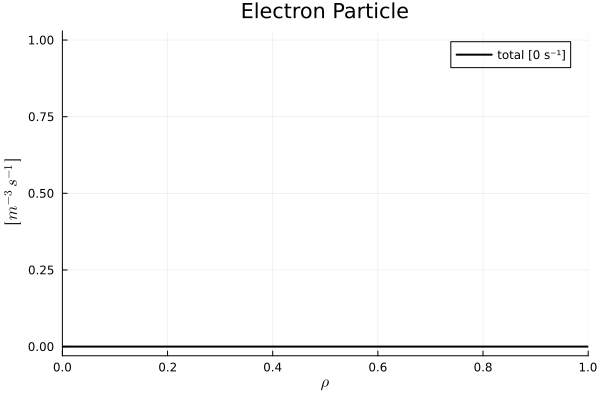

​


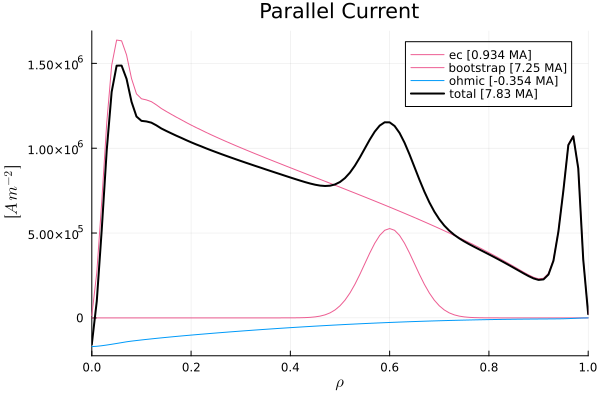

​


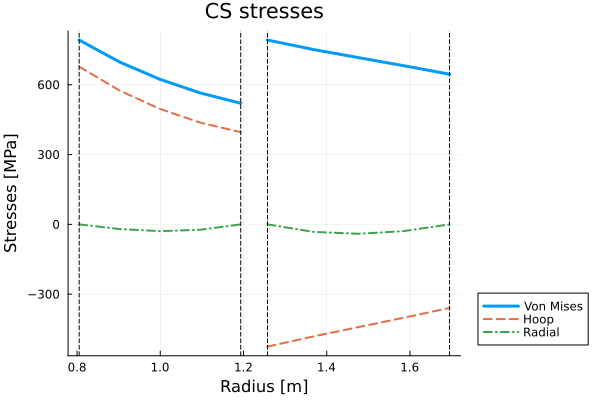

In [10]:
FUSE.digest(dd)